## Grid Search

In [1]:
from typing import Dict, List
from ddnn.nn import *
from ddnn.data import *
from ddnn.validation import *

In [2]:
net = NeuralNetwork(
    [
        LinearLayer((8, 16)),
        ActivationFunction(),
    ]
)
estimator = Estimator(net) # fix to work without anything
grid = {}
grid["layers"] = [
    [(128, "ReLU"), (2, "linear")],        
]
grid["learning_rate"] = [1e-2, 5e-3] # 1e-2, 1e-3
grid["momentum_coefficient"] = [0.1] # 0.1, 0.5
grid["optimizer"] = ["SGD"]
grid["loss"] = ["MSE"]
grid["l2_coefficient"] = [1e-1]      # 1e-2, 1e-3
grid["batchsize"] = [-1]             # -1, 128
grid["weight_initializer"] = [ "glorot_uniform"]
# grid['fan_mode'] = ['fan_in', 'fan_out']
selector = GridSearch(estimator, grid, 523552)
comb=1
for k,v in grid.items():
    comb*= len(v)
print(comb)

4


In [3]:
data = read_ML_cup("train")
# data = read_monks(1, "train")
data, test = train_valid_split(data, seed=123)

In [4]:
logger = Logger(estimator, ["MSE"], every=10)

In [5]:
results = selector.k_fold(
    data,
    5,
    n_epochs=1500,
    loss_list=["MSE"],
    early_stopping=(20, 3, 1e-4),
    seed=123,
    on_fold_change=logger.update_fold,
    on_hp_change=logger.update_hp,
    training_callback=logger,
)

{'layers': [(128, 'tanh'), (2, 'linear')], 'learning_rate': 0.01, 'momentum_coefficient': 0.1, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.1, 'batchsize': -1, 'weight_initializer': 'glorot_uniform'}
{'layers': [(128, 'tanh'), (2, 'linear')], 'learning_rate': 0.005, 'momentum_coefficient': 0.1, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.1, 'batchsize': -1, 'weight_initializer': 'glorot_uniform'}
{'layers': [(16, 'tanh'), (16, 'tanh'), (16, 'tanh'), (2, 'linear')], 'learning_rate': 0.01, 'momentum_coefficient': 0.1, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.1, 'batchsize': -1, 'weight_initializer': 'glorot_uniform'}
{'layers': [(16, 'tanh'), (16, 'tanh'), (16, 'tanh'), (2, 'linear')], 'learning_rate': 0.005, 'momentum_coefficient': 0.1, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.1, 'batchsize': -1, 'weight_initializer': 'glorot_uniform'}


In [6]:
# save to file
import json
with open("trial.json", "w") as fp:
    json.dump(logger._scores, fp)

## Plotting

In [7]:
# open with pandas
import pandas as pd
import json
with open("trial.json", "r") as fp:
    scores = json.load(fp)
df = pd.json_normalize(scores)
df["hp.layers"] = df["hp.layers"].astype(str) # convert layers to str repr

In [8]:
from ipywidgets.widgets import interact_manual, interact
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

interactive(children=(Dropdown(description='loss', options=('MSE',), value='MSE'), Dropdown(description='hp.la…

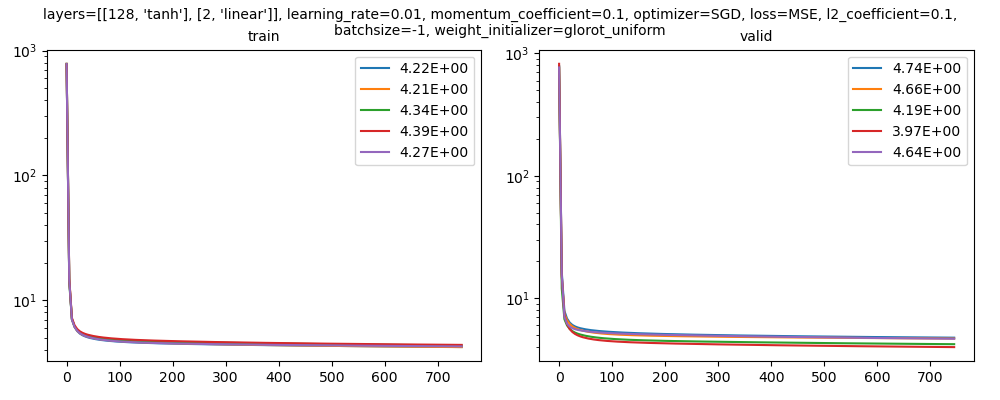

In [9]:
%matplotlib ipympl

# select loss, hyper get 2 plots one with train one with valid
fig, axs = plt.subplots(1,2, figsize=(10,4))

# hyperparameters in grid
params = {
    k: df[k].unique() 
    for k in df.columns[df.columns.str.startswith("hp.")]
}
# hyperparameters in grid with at least 2 values
fparams = {
    k: v 
    for k,v in params.items()
    if len(v) > 1
}

@interact(
    loss = logger._losses,
    **fparams
)
def plot_results(loss, **kwargs):
    row_selection = pd.Series([True]*df.shape[0])
    for k,v in kwargs.items():
        row_selection &= (df[k] == v)
    rows = df[row_selection]

    # add parameter to title if missing
    for k in params:
        if k not in kwargs:
            kwargs[k] = params[k][0]

    fig.suptitle(", ".join([f"{k[3:]}={v}" for k,v in kwargs.items()]), wrap=True, fontsize=10)
    fig.tight_layout()
    for where, ax in zip(["train", "valid"], axs):
        col_selection = rows.columns.str.endswith(f"{where}.{loss}")
        data = rows[rows.columns[col_selection]]

        ys = [y for y in data.values][0]
        if loss != "binary_accuracy":
            bests = [min(y) for y in ys]
            form = "{:.2E}"
            logplot = True
        else:
            bests = [max(y) for y in ys]
            form = "{:.2}"
            logplot = False

        ax.clear()
        ax.set_title(where, fontsize=10)
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*5))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        for y,best in zip(ys, bests):
            ax.plot(y, label=f"{form.format(best)}")
        ax.legend()

In [10]:
results

[{'parameters': {'layers': [(16, 'tanh'),
    (16, 'tanh'),
    (16, 'tanh'),
    (2, 'linear')],
   'learning_rate': 0.01,
   'momentum_coefficient': 0.1,
   'optimizer': 'SGD',
   'loss': 'MSE',
   'l2_coefficient': 0.1,
   'batchsize': -1,
   'weight_initializer': 'glorot_uniform'},
  'test_loss_avg': {'MSE': 3.7990472387617125},
  'test_loss_std': {'MSE': 0.31478384605684223},
  'seed': 3189883825594177726,
  'n_epochs_list': [1481, 1481, 1481, 1481, 1481],
  'n_epoch_avg': 1481.0,
  'n_epoch_std': 0.0,
  'train_loss_avg': 3.604450221722999,
  'train_loss_std': 0.07536614318485348},
 {'parameters': {'layers': [(16, 'tanh'),
    (16, 'tanh'),
    (16, 'tanh'),
    (2, 'linear')],
   'learning_rate': 0.005,
   'momentum_coefficient': 0.1,
   'optimizer': 'SGD',
   'loss': 'MSE',
   'l2_coefficient': 0.1,
   'batchsize': -1,
   'weight_initializer': 'glorot_uniform'},
  'test_loss_avg': {'MSE': 4.188025686002176},
  'test_loss_std': {'MSE': 0.3284896283434074},
  'seed': 4474309407931